In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import fitsio
import astropy.io.fits as fits
import sys, os, time, argparse, glob
import warnings; warnings.simplefilter('ignore')

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/shared/desitarget/')
from targetmask import bgs_mask, desi_mask

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

import matplotlib
matplotlib.rc('font', **font)

In [5]:
!ls /project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/

targets-dr8-hp-0,63.fits
targets-dr8-hp-1,5,11,50,55,60,83,84,86,89,91,98,119,155,158,174,186,187,190.fits
targets-dr8-hp-10,66,69,75,87,105.fits
targets-dr8-hp-13,15.fits
targets-dr8-hp-16,81,99,104,106,107,176.fits
targets-dr8-hp-17,34,92,142,181,191.fits
targets-dr8-hp-18,45,46.fits
targets-dr8-hp-19,37,40.fits
targets-dr8-hp-2,33,80,116,140,141.fits
targets-dr8-hp-20,29,126.fits
targets-dr8-hp-21,30,109.fits
targets-dr8-hp-22,42,111.fits
targets-dr8-hp-23,43,57,131.fits
targets-dr8-hp-25,41,79,137.fits
targets-dr8-hp-26,54,65,70,133.fits
targets-dr8-hp-27,56,127,179.fits
targets-dr8-hp-28,44,115,136.fits
targets-dr8-hp-3,32,95,100,101,103,123,182.fits
targets-dr8-hp-35,38,74,130.fits
targets-dr8-hp-39,132,157,180.fits
targets-dr8-hp-47,121.fits
targets-dr8-hp-48,71,90,144,152,160,183.fits
targets-dr8-hp-49,64,68,82,143.fits
targets-dr8-hp-51,93,117,118,120,124,146,173,184,185,188,189.fits
targets-dr8-hp-52,73,110,138.fits
targets-dr8-hp-53,88,102,108,128,134.fits
targets-dr8-hp-59,

# Load desitarget catalogue

We're going to load the latest target catalogue (DR8, 7th July 2019: see Adam's email -- [decam-chatter 9932] Preliminary DR8 Target Release). 
The catalogue is divided in subfiles with healpix structure (as described in desitarget tutorial: https://github.com/desihub/desitarget/blob/master/doc/nb/how-to-run-target-selection.ipynb) and the path is:

        /project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/
        

In [14]:
# Set-up the directory of HEALPixel-split files we created in the previous subsection.
hpdirname = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/'

# The various pieces of code for reading in targets.
from desitarget.io import read_targets_in_hp, read_targets_in_box, read_targets_in_cap

# Read targets in an RAmin, RAmax, Decmin, Decmax "rectangle".
radecbox = [120,122,32,34]
df = read_targets_in_box(hpdirname, radecbox)

## BGS example

To check the columns of the catalogue run:
    
        df.dtype.names
        
To select BGS targets you need to look into `BGS_TARGET` column but also, it's necesary to load `bgs_mask` which contains the information of the bits asociated to all bright time targets in the `BGS_TARGET` column. This module can be load with the followiing lines:

    sys.path.insert(0, '/global/homes/q/qmxp55/DESI/shared/desitarget/')
    from targetmask import bgs_mask

'bgs_mask' was already loaded at the top of this notebook. 

Below is an example of how to extract the BGS targets.

In [17]:
#creating an array of booleans with the same length as desitarget catalogue
primary = np.ones_like(df['RA'], dtype='?') 

BGS = primary.copy()
#Filling the boolean array with BGS targets only as TRUE.
bgs_faint = ((np.uint64(df['BGS_TARGET']) & np.uint64(bgs_mask['BGS_FAINT']))!=0)
bgs_bright = ((np.uint64(df['BGS_TARGET']) & np.uint64(bgs_mask['BGS_BRIGHT']))!=0)

BGS &= (bgs_bright) | (bgs_faint)


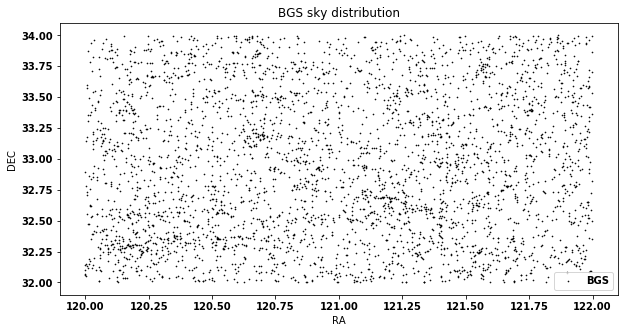

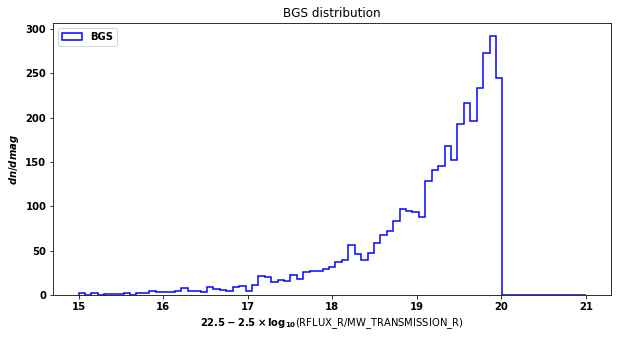

In [22]:
def flux_to_mag(flux):
    mag = 22.5 - 2.5*np.log10(flux)
    return mag

plt.figure(figsize=(10, 5))
plt.title(r'BGS sky distribution')
plt.scatter(df['RA'][BGS], df['DEC'][BGS], s=0.4, color='k', label='BGS')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))

rmag = flux_to_mag(df['FLUX_R']/df['MW_TRANSMISSION_R'])

bins1 = np.linspace(15, 21, 80)

c1 = plt.hist(rmag[BGS], bins=bins1, cumulative=False, histtype='step', align='mid', 
        color='blue', linewidth=1.5, label=r'BGS')

plt.legend(loc='upper left')

plt.xlabel(r'$22.5 - 2.5\times \log_{10}$(%s/%s)' %('RFLUX_R', 'MW_TRANSMISSION_R'))
plt.ylabel(r'$dn/dmag$')
plt.title(r'BGS distribution')
#plt.grid()

plt.show()

## ELG's example

To check the columns of the catalogue run:
    
        df.dtype.names
        
To mask for ELG targets and BRIGHTSTARINBLOB, you need to look into 'BRIGHTSTARINBLOB' and 'DESI_TARGET' columns but also, it's necesary to load 'desi_mask' which contains the information of the bits asociated to all Dark time targets in the 'DESI_TARGET' column. This module can be load with the followiing lines:

    sys.path.insert(0, '/global/homes/q/qmxp55/DESI/shared/desitarget/')
    from targetmask import desi_mask

'desi_mask' was already loaded at the top of this notebook. 

Below is an example of how to extract the ELG targets.

In [6]:
#creating an array of booleans with the same length as desitarget catalogue
primary = np.ones_like(df['RA'], dtype='?') 

ELG = primary.copy()
BRIBLOB = primary.copy()
#Filling the boolean array with ELG targets only as TRUE.
ELG &= (np.uint64(df['DESI_TARGET']) & np.uint64(desi_mask['ELG']))!=0
#Filling the boolean array with BRIGHTSTARINBLOB
BRIBLOB &= df['BRIGHTSTARINBLOB']

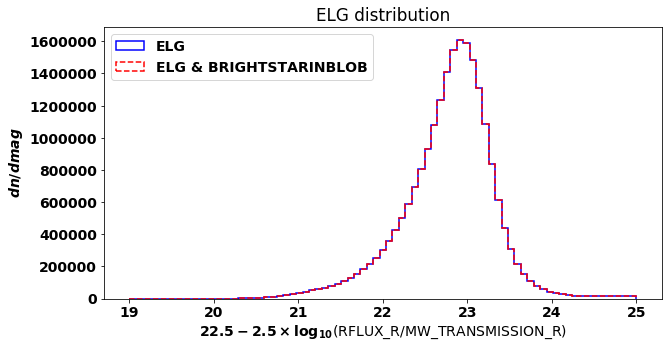

In [7]:
def flux_to_mag(flux):
    mag = 22.5 - 2.5*np.log10(flux)
    return mag

plt.figure(figsize=(10, 5))

rmag = flux_to_mag(df['FLUX_R']/df['MW_TRANSMISSION_R'])

bins1 = np.linspace(19, 25, 80)

c1 = plt.hist(rmag[ELG], bins=bins1, cumulative=False, histtype='step', align='mid', 
        color='blue', linewidth=1.5, label=r'ELG')

c2 = plt.hist(rmag[(ELG) & (~BRIBLOB)], bins=bins1, cumulative=False, histtype='step', align='mid', 
        color='r', linewidth=1.5, linestyle='--', label=r'ELG & BRIGHTSTARINBLOB')

plt.legend(loc='upper left')

plt.xlabel(r'$22.5 - 2.5\times \log_{10}$(%s/%s)' %('RFLUX_R', 'MW_TRANSMISSION_R'))
plt.ylabel(r'$dn/dmag$')
plt.title(r'ELG distribution')
#plt.grid()

plt.show()

# Load the randoms

Example of randoms and how to mask BRIGHTSTARINBLOB.

In [5]:
randoms=fitsio.read('/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/randoms-dr7.1-0.22.0-1.fits', 
                    columns=['RA', 'DEC', 'MASKBITS'],upper=True, ext=1)

In [6]:
ran_briblob = np.ones_like(randoms, dtype='?')
#Masking the BRIGHTSTARINBLOB of randoms
ran_briblob &= (np.uint64(randoms['MASKBITS']) & np.uint64(0x2))!=0

In [7]:
print('%2.2g %% of randoms are in BRIGHTSTARINBLOB' %(np.sum(ran_briblob)*100/len(randoms)))

1.1 % of randoms are in BRIGHTSTARINBLOB


# DEV ZONE...

In [3]:
dr8b = fitsio.read('/project/projectdirs/desi/target/catalogs/dr8b/0.29.1/main/targets-dr8b-0.29.1.fits')

In [4]:
dr8b.dtype.names

('RELEASE',
 'BRICKID',
 'BRICKNAME',
 'BRICK_OBJID',
 'MORPHTYPE',
 'RA',
 'DEC',
 'RA_IVAR',
 'DEC_IVAR',
 'DCHISQ',
 'EBV',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_W1',
 'FLUX_W2',
 'FLUX_W3',
 'FLUX_W4',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'FLUX_IVAR_W1',
 'FLUX_IVAR_W2',
 'FLUX_IVAR_W3',
 'FLUX_IVAR_W4',
 'MW_TRANSMISSION_G',
 'MW_TRANSMISSION_R',
 'MW_TRANSMISSION_Z',
 'MW_TRANSMISSION_W1',
 'MW_TRANSMISSION_W2',
 'MW_TRANSMISSION_W3',
 'MW_TRANSMISSION_W4',
 'NOBS_G',
 'NOBS_R',
 'NOBS_Z',
 'FRACFLUX_G',
 'FRACFLUX_R',
 'FRACFLUX_Z',
 'FRACMASKED_G',
 'FRACMASKED_R',
 'FRACMASKED_Z',
 'FRACIN_G',
 'FRACIN_R',
 'FRACIN_Z',
 'ALLMASK_G',
 'ALLMASK_R',
 'ALLMASK_Z',
 'WISEMASK_W1',
 'WISEMASK_W2',
 'PSFDEPTH_G',
 'PSFDEPTH_R',
 'PSFDEPTH_Z',
 'GALDEPTH_G',
 'GALDEPTH_R',
 'GALDEPTH_Z',
 'FRACDEV',
 'FRACDEV_IVAR',
 'SHAPEDEV_R',
 'SHAPEDEV_R_IVAR',
 'SHAPEDEV_E1',
 'SHAPEDEV_E1_IVAR',
 'SHAPEDEV_E2',
 'SHAPEDEV_E2_IVAR',
 'SHAPEEXP_R',
 'SHAPEEXP_R_IVAR',
 'SHAPEEXP_E1